In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read Benchmark Data

In [58]:
benchmark_results_path = "../results/"
data = []
for root, dirs, files in os.walk(benchmark_results_path):
    for file in files:
        if file.endswith(".csv"):
            df_ = pd.read_csv(os.path.join(root, file))
            data.append(df_)

df = pd.concat(data)

In [59]:
df.head()

,model_name,env_id,prompt_chain,context_length,episode_reward,episode_length
0,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0,295.0,621
1,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0,180.0,491
2,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0,150.0,365
0,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,cot,0,15.0,681
1,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,cot,0,10.0,309


### Aggregate Results for each Benchmark run

In [60]:
df['mean_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'context_length'])['episode_reward'].transform('mean')
df['std_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'context_length'])['episode_reward'].transform('std')
df['mean_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'context_length'])['episode_length'].transform('mean')
df['std_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'context_length'])['episode_length'].transform('std')

### Plot

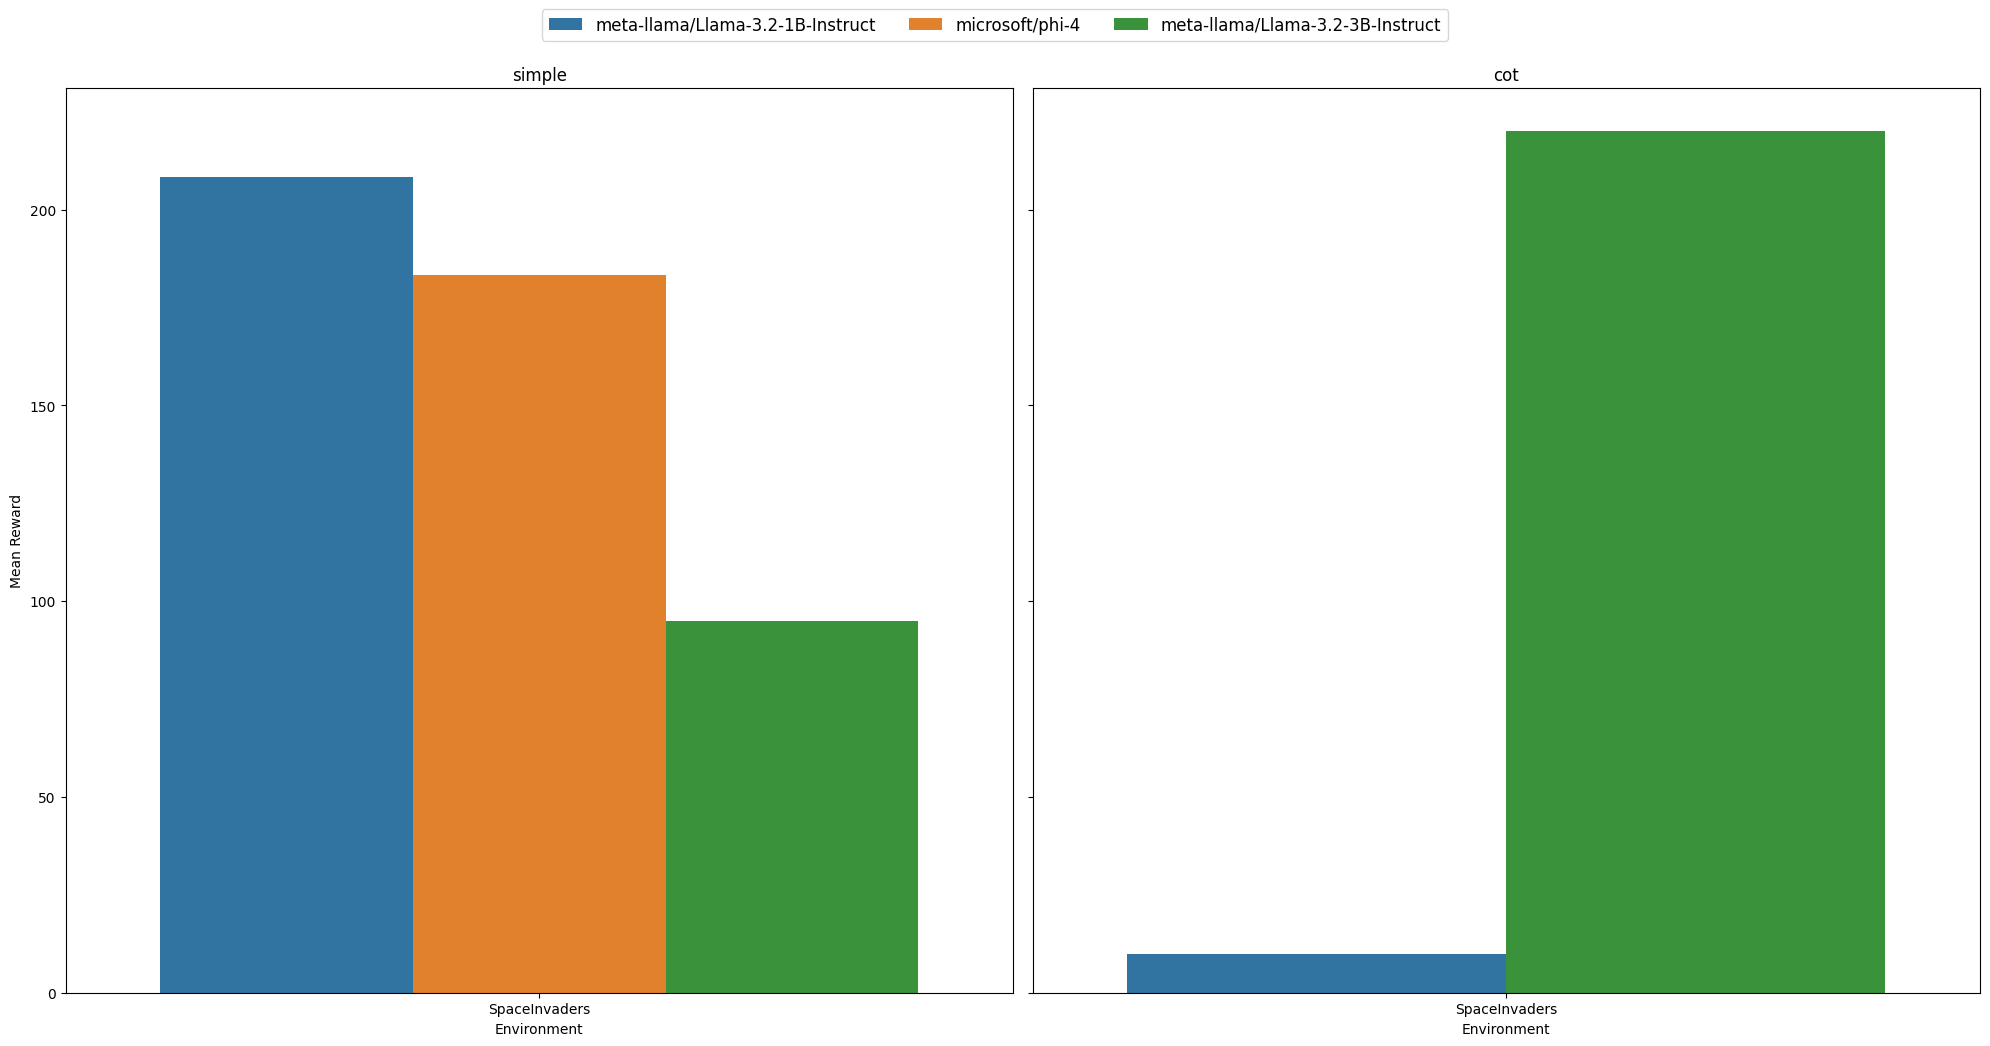

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette based on unique model names
unique_models = df['model_name'].unique()
palette = dict(zip(unique_models, sns.color_palette("tab10", len(unique_models))))

# Create subplots
unique_prompt_chains = df['prompt_chain'].unique()
fig, axs = plt.subplots(1, len(unique_prompt_chains), figsize=(20, 10), sharey=True)

for i, prompt_chain in enumerate(unique_prompt_chains):
    df_ = df[df['prompt_chain'] == prompt_chain]
    sns.barplot(x='env_id', y='mean_reward', data=df_, hue='model_name', ax=axs[i], palette=palette)
    axs[i].set_title(prompt_chain)
    axs[i].set_ylabel('Mean Reward')
    axs[i].set_xlabel('Environment')

    # Remove individual subplot legends
    axs[i].legend_.remove()

# Create a single shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(unique_models), bbox_to_anchor=(0.5, 1.05), fontsize='large')

plt.tight_layout()
plt.show()
